In [65]:
from typing import Dict, List, Optional, Union
import random
import torch
import torch.nn as nn

from ltx_video.models.autoencoders.causal_video_autoencoder import (
    CausalVideoAutoencoder,
)
from ltx_video_lora import *
from peft import PeftModel, get_peft_model, LoraConfig, get_peft_model_state_dict, set_peft_model_state_dict
from safetensors.torch import load_file, save_file

In [71]:
from einops import rearrange
from ltx_video.models.autoencoders.vae_encode import (
    get_vae_size_scale_factor,
    latent_to_pixel_coords,
    vae_decode,
    vae_encode,
)

In [2]:
MODEL_ID = "./pretrained/ltx-video-2b-v0.9.5.safetensors"
vae_dtype = torch.bfloat16
vae = CausalVideoAutoencoder.from_pretrained(MODEL_ID, torch_dtype=vae_dtype, cache_dir=None)


In [ ]:
trans = load_diffusion_models()["transformer"]


In [51]:
file = "/media/eisneim/4T/ltx_0.9.5/49x1024x576/negative_49x1024x576/action0_6k_0.8_stg1.2_[18]_ehance3_c0.94_49.pt"
data = torch.load(file, weights_only=True)
latent = data["latents"]
print(latent.shape)
prompt_embeds = data["embedds"]
print("prompt_embeds", prompt_embeds.shape)
prompt_attention_mask = data["masks"]
print("prompt_attention_mask", prompt_attention_mask.shape)
info = data["meta_info"]
print(info)

torch.Size([1, 4032, 128])
prompt_embeds torch.Size([1, 128, 4096])
prompt_attention_mask torch.Size([1, 128])
[{'num_frames': 7, 'height': 18, 'width': 32}]


In [ ]:
latents, pixel_coords, conditioning_mask, num_cond_latents = (
    self.prepare_conditioning(
        conditioning_items=conditioning_items,
        init_latents=latents,
        num_frames=num_frames,
        height=height,
        width=width,
        vae_per_channel_normalize=vae_per_channel_normalize,
        generator=generator,
    )
)
init_latents = latents.clone()  # Used for image_cond_noise_update

In [69]:
def pack_latents(latents: torch.Tensor, patch_size: int = 1, patch_size_t: int = 1) -> torch.Tensor:
    batch_size, num_channels, num_frames, height, width = latents.shape
    post_patch_num_frames = num_frames // patch_size_t
    post_patch_height = height // patch_size
    post_patch_width = width // patch_size
    latents = latents.reshape(
        batch_size,
        -1,
        post_patch_num_frames,
        patch_size_t,
        post_patch_height,
        patch_size,
        post_patch_width,
        patch_size,
    )
    latents = latents.permute(0, 2, 4, 6, 1, 3, 5, 7).flatten(4, 7).flatten(1, 3)
    return latents

# image 1 x 704 x 480
latents = torch.randn(1, 128, 7, 15, 22)
packed = pack_latents(latents)
print(packed.shape)

torch.Size([1, 2310, 128])


In [73]:
pix_coords = latent_to_pixel_coords(coords, vae)
print(pix_coords.shape)

torch.Size([1, 3, 2310])


In [63]:
def get_latent_coords(
    latent_num_frames, latent_height, latent_width, batch_size, device,
    _patch_size=(1, 1, 1)
):
    """
    Return a tensor of shape [batch_size, 3, num_patches] containing the
        top-left corner latent coordinates of each latent patch.
    The tensor is repeated for each batch element.
    """
    latent_sample_coords = torch.meshgrid(
        torch.arange(0, latent_num_frames, _patch_size[0], device=device),
        torch.arange(0, latent_height, _patch_size[1], device=device),
        torch.arange(0, latent_width, _patch_size[2], device=device),
    )
    latent_sample_coords = torch.stack(latent_sample_coords, dim=0)
    latent_coords = latent_sample_coords.unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)
    latent_coords = rearrange(
        latent_coords, "b c f h w -> b c (f h w)", b=batch_size
    )
    return latent_coords
    
# coords = get_latent_coords(7, 480//32, 704//32, 1, "cpu")
# print(coords.shape)


def forward_pass(
    transformer: Transformer3DModel,
    vae: CausalVideoAutoencoder,
    prompt_embeds: torch.Tensor,
    prompt_attention_mask: torch.Tensor,
    latents: torch.Tensor,
    noisy_latents: torch.Tensor,
    timesteps: torch.LongTensor,
    num_frames: int,
    height: int,
    width: int,
) -> torch.Tensor:
    
    bsz =  latents.size(0)
    latent_coords = get_latent_coords(num_frames, height, width, bsz, latents.device)
    pixel_coords = latent_to_pixel_coords(latent_coords, vae)
    
    # num_conds = 1
    # pixel_coords = torch.cat([pixel_coords] * num_conds)
    fractional_coords = pixel_coords.to(torch.float32)
    fractional_coords[:, 0] = fractional_coords[:, 0] * (1.0 / frame_rate)
    
    noise_pred = transformer(
        latent_model_input.to(transformer.dtype),
        indices_grid=fractional_coords,
        encoder_hidden_states=prompt_embeds.to(
            transformer.dtype
        ),
        encoder_attention_mask=prompt_attention_mask,
        timestep=timesteps,
        return_dict=False,
    )[0]

    return {"latents": noise_pred}


torch.Size([1, 3, 2310])


In [ ]:
forward_pass(trans, )

In [17]:
from transformers import Conv1D

def get_all_linear_names(model):
    # Create a list to store the layer names
    layer_names = []
    
    # Recursively visit all modules and submodules
    for name, module in model.named_modules():
        # if "simpleMlp" in name:
        #     continue
        # Check if the module is an instance of the specified layers
        if isinstance(module, (torch.nn.Linear, torch.nn.Embedding, torch.nn.Conv2d, Conv1D)):
            # model name parsing 

            layer_names.append(name)
    
    return layer_names

# target_mods = ""
target_mods =  get_all_linear_names(trans)

transformer_lora_config = LoraConfig(
    r=256,
    lora_alpha=256,
    # init_lora_weights="pissa",
    init_lora_weights=True,
    target_modules=target_mods,
    lora_dropout=0.01,
)
# self.transformer.add_adapter(transformer_lora_config)
transformer = get_peft_model(trans, transformer_lora_config)

In [ ]:
prev_check = "data/pytorch_lora_weights.safetensors"
ss = load_file(prev_check)
prev_transformer_state_dict = {
    f'{k.replace("transformer.", "base_model.model.")}': v
    for k, v in ss.items()
    if k.startswith("transformer.")
}
    
set_peft_model_state_dict(transformer, prev_transformer_state_dict)

In [38]:
transformer.save_pretrained("data/use_pretrained")

In [40]:
new_trans = PeftModel.from_pretrained(trans, "data/use_pretrained")

In [28]:
save_file(transformer_lora_layers_to_save, "data/pytorch_lora_weights.safetensors")

In [ ]:
aa = load_file("data/use_pretrained/adapter_model.safetensors")
aa

In [ ]:
ss

In [31]:
save_file(ss, "data/pytorch_lora_weights2.safetensors")

In [ ]:
transformer.state_dict()

In [60]:
aa = torch.arange(10)/1.0
bb = torch.arange(10)/2.0
print(aa)
print(bb)
print("lerp", torch.lerp(aa, bb, 0.1))
print(aa + 0.1 * (bb - aa))
# bb * 1 + aa - 1 * aa = bb * w + aa * (1- w)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
        4.5000])
lerp tensor([0.0000, 0.9500, 1.9000, 2.8500, 3.8000, 4.7500, 5.7000, 6.6500, 7.6000,
        8.5500])
tensor([0.0000, 0.9500, 1.9000, 2.8500, 3.8000, 4.7500, 5.7000, 6.6500, 7.6000,
        8.5500])


In [74]:
import matplotlib.pyplot as plt

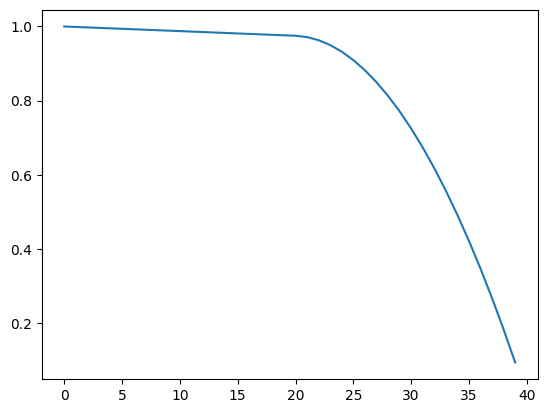

In [75]:
aa = [1.0000, 0.9987, 0.9975, 0.9962, 0.9950, 0.9937, 0.9925, 0.9912, 0.9900,
        0.9887, 0.9875, 0.9862, 0.9850, 0.9837, 0.9825, 0.9812, 0.9800, 0.9787,
        0.9775, 0.9762, 0.9750, 0.9714, 0.9630, 0.9499, 0.9320, 0.9094, 0.8820,
        0.8499, 0.8130, 0.7714, 0.7250, 0.6739, 0.6180, 0.5574, 0.4920, 0.4219,
        0.3470, 0.2674, 0.1830, 0.0939]
plt.plot(aa)

In [91]:
dd = torch.load("/media/eisneim/4T/ltx_0.9.5/49x1280x704/game_slow_49x1280x704/wd_1742702669_2_0.pt", weights_only=True)
print(len(dd["latents"]) * 49 / 24)

30.625


In [85]:
dd["latents"].shape

torch.Size([8, 6160, 128])

In [89]:
len(dd["latents"]) * 49 / 24

16.333333333333332